In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

from bechdelai.processing.video import extract_frames_from_videos
from bechdelai.vision.frame import Frame
from bechdelai.vision.face_detection import FaceDetector

###### Interesting tools
- OpenCV
- DeepFace
- RetinaFace
- Moviepy
- YOLO
- https://github.com/open-mmlab/mmaction2

##### References
- https://www.analyticsvidhya.com/blog/2018/09/deep-learning-video-classification-python/
- https://github.com/HuaizhengZhang/Awsome-Deep-Learning-for-Video-Analysis

# Exploration on first video

In [3]:
path = "../data/sample_videos/Andy Samberg dances on Megatron Man.mp4"

## Frame extraction
- https://www.analyticsvidhya.com/blog/2018/09/deep-learning-video-classification-python/

In [3]:
extract_frames_from_videos(path,"megatron")

ERROR! Session/line number was not unique in database. History logging moved to new session 120
Done!


## Face detection
- https://github.com/opencv/opencv/tree/master/data/haarcascades
- https://www.pyimagesearch.com/2021/04/05/opencv-face-detection-with-haar-cascades/
- https://realpython.com/face-recognition-with-python/

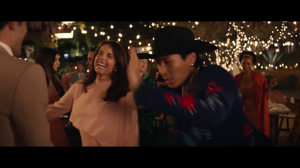

In [4]:
frame = Frame('megatron/frame9.jpg')
frame.resize(width = 300)
frame.show()

In [5]:
detector = FaceDetector()

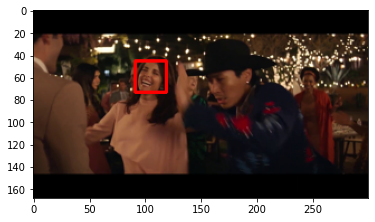

In [6]:
frame.show_faces(detector,scale_factor = 1.1,min_neighbors = 3)

In [7]:
faces = frame.extract_faces(detector,scale_factor = 1.1,min_neighbors = 3)

In [8]:
faces[0]

## All faces extraction

In [9]:
from bechdelai.vision.frames import Frames
from bechdelai.vision.face_detection import FaceDetector

detector = FaceDetector()

In [10]:
frames = Frames(path = "megatron")
frames.resize(width = 600)

  0%|          | 0/84 [00:00<?, ?it/s]

In [27]:
frames.extract_faces(
    detector = detector,
    deepface_check = True,
    scale_factor = 1.3,
    min_neighbors = 3,
    face_size = (200,200),
    deepface_backend = "ssd"
)

  0%|          | 0/84 [00:00<?, ?it/s]

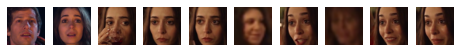

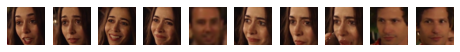

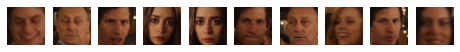

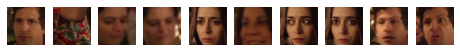

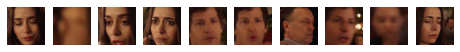

<Figure size 576x72 with 0 Axes>

In [12]:
frames.show_all_faces()

## Face analysis

A face analysis can be done using DeepFace pretrained algorithms, <br>
Such function is embedded in the ``frame.face`` object

{'emotion': {'angry': 4.10197526216507, 'disgust': 0.6817139219492674, 'fear': 92.03020334243774, 'happy': 0.16629358287900686, 'sad': 2.742575667798519, 'surprise': 0.2360318787395954, 'neutral': 0.04120543890167028}, 'dominant_emotion': 'fear', 'region': {'x': 6, 'y': 7, 'w': 84, 'h': 84}, 'age': 33, 'gender': 'Man', 'race': {'asian': 2.6904720813035965, 'indian': 4.640196263790131, 'black': 0.9057926014065742, 'white': 38.111597299575806, 'middle eastern': 22.172439098358154, 'latino hispanic': 31.479498744010925}, 'dominant_race': 'white'}


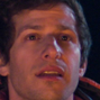

In [19]:
print(frames.faces[0].analyze())
frames.faces[0]

{'emotion': {'angry': 29.655379056930542, 'disgust': 7.990705966949463, 'fear': 26.776614785194397, 'happy': 2.4707090109586716, 'sad': 28.784584999084473, 'surprise': 2.7037257328629494, 'neutral': 1.61827951669693}, 'dominant_emotion': 'angry', 'region': {'x': 8, 'y': 12, 'w': 82, 'h': 82}, 'age': 27, 'gender': 'Woman', 'race': {'asian': 0.026342619094066322, 'indian': 0.052782398415729403, 'black': 0.00160517174663255, 'white': 84.17929410934448, 'middle eastern': 11.001452803611755, 'latino hispanic': 4.738526418805122}, 'dominant_race': 'white'}


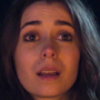

In [20]:
print(frames.faces[1].analyze())
frames.faces[1]

## Embeddings Analysis

In [24]:
from bechdelai.vision.face_recognition import FaceAnalyzer

In [68]:
%%time 

analyzer = FaceAnalyzer()
analyzer.load_vgg_model()

faces_array = analyzer.make_array_dataset(frames.faces)
embeddings = analyzer.make_embeddings(faces_array)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Wall time: 22.4 s


In [74]:
embeddings2D = analyzer.reduce_embeddings(embeddings,n_components=2,metric = "cosine",n_neighbors = 50)


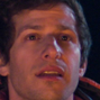
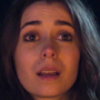
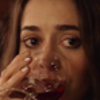
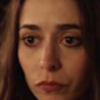
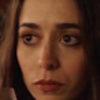
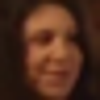
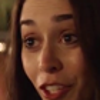
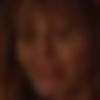
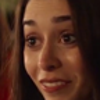
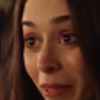
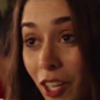
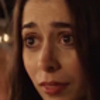
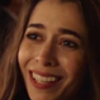
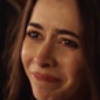
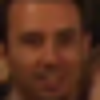
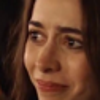
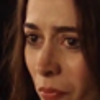
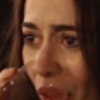
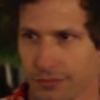
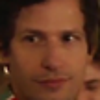
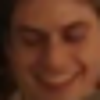
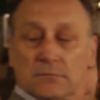
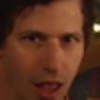
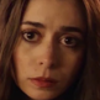
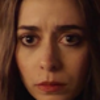
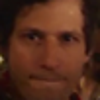
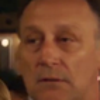
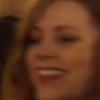
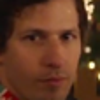
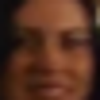
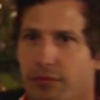
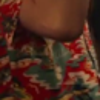
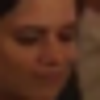
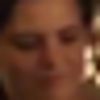
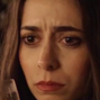
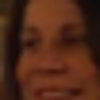
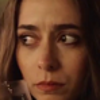
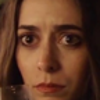
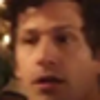
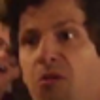
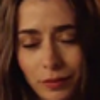
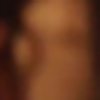
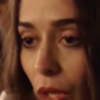
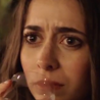
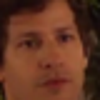
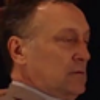
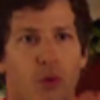
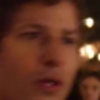
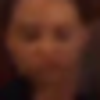
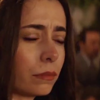

In [75]:
analyzer.show_embeddings2D(embeddings2D,frames.faces)

### Clustering

In [78]:
embeddings2D_with_clusters,clusters = analyzer.cluster_embeddings(embeddings2D,eps = 1) 
embeddings2D_with_clusters.head()

x         y  cluster
0  10.238999  9.460876        0
1  10.315332  6.637794        1
2  10.824081  7.425153        1
3  11.759419  7.361132        1
4  11.543812  7.665568        1


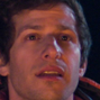
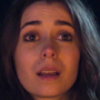
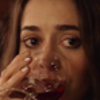
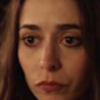
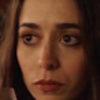
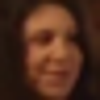
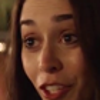
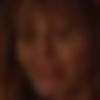
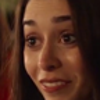
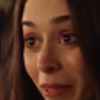
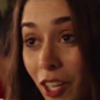
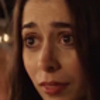
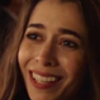
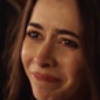
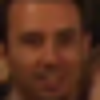
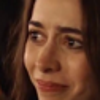
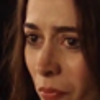
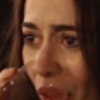
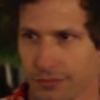
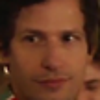
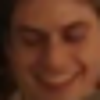
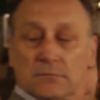
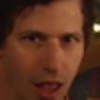
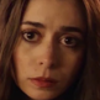
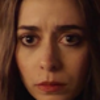
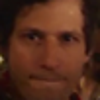
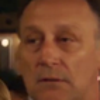
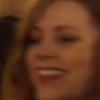
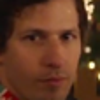
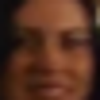
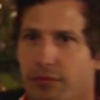
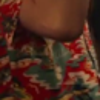
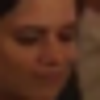
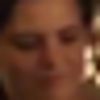
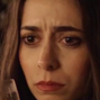
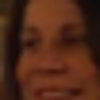
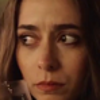
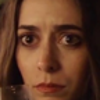
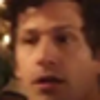
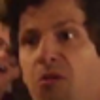
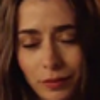
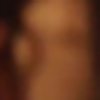
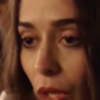
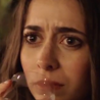
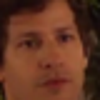
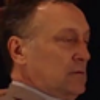
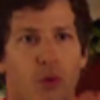
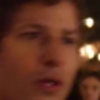
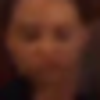
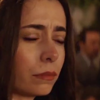

In [79]:
analyzer.show_embeddings2D(embeddings2D_with_clusters,frames.faces)

Answers question 1

In [94]:
clusters_cat = pd.DataFrame([
    [0,"man"],
    [1,"woman"],
    [2,"outlier"],   
],columns = ["cluster","gender"])
clusters_cat

cluster   gender
0        0      man
1        1    woman
2        2  outlier

## Visualization of clusters over time (by frame)

In [100]:
frames.faces_metadata["cluster"] = clusters
frames.faces_metadata["count"] = 1
frames.faces_metadata = frames.faces_metadata.merge(clusters_cat,on="cluster").sort_values("frame_id")

Answers question 2

In [106]:
faces_group = frames.faces_metadata.groupby(["frame_id","gender"],as_index = False)["count"].sum()
faces_group.loc[faces_group["count"] >= 2]

frame_id gender  count
25        34    man      2
44        75    man      2

In [97]:
import plotly.express as px
px.bar(
    frames.faces_metadata.assign(count = lambda x : 1),
    x = "frame_id",y = "count",color = "gender"
)

# Supervised approach
Instead of using a clustering method, use face identification for each face using a reference database

In [42]:
from bechdelai.vision.face_recognition import FaceAnalyzer
analyzer = FaceAnalyzer()

In [43]:
matches = analyzer.match_faces(frames.faces,db_path = "./db")

  0%|          | 0/50 [00:00<?, ?it/s]

There are  6  representations found in  representations_vgg_face.pkl
find function lasts  0.6432700157165527  seconds
There are  6  representations found in  representations_vgg_face.pkl
find function lasts  0.9082794189453125  seconds
There are  6  representations found in  representations_vgg_face.pkl
find function lasts  0.5074563026428223  seconds
There are  6  representations found in  representations_vgg_face.pkl
find function lasts  0.5552599430084229  seconds
There are  6  representations found in  representations_vgg_face.pkl
find function lasts  0.5212690830230713  seconds
There are  6  representations found in  representations_vgg_face.pkl
find function lasts  0.5107173919677734  seconds
There are  6  representations found in  representations_vgg_face.pkl
find function lasts  0.5130202770233154  seconds
There are  6  representations found in  representations_vgg_face.pkl
find function lasts  0.45054078102111816  seconds
There are  6  representations found in  representations

find function lasts  0.5150411128997803  seconds
There are  6  representations found in  representations_vgg_face.pkl
find function lasts  0.5332987308502197  seconds
There are  6  representations found in  representations_vgg_face.pkl
find function lasts  0.49915313720703125  seconds
There are  6  representations found in  representations_vgg_face.pkl
find function lasts  0.5621235370635986  seconds
There are  6  representations found in  representations_vgg_face.pkl
find function lasts  0.5302672386169434  seconds
There are  6  representations found in  representations_vgg_face.pkl
find function lasts  0.46832942962646484  seconds
There are  6  representations found in  representations_vgg_face.pkl
find function lasts  0.5669786930084229  seconds
There are  6  representations found in  representations_vgg_face.pkl
find function lasts  0.856776237487793  seconds
There are  6  representations found in  representations_vgg_face.pkl
find function lasts  0.7255322933197021  seconds
There 

find function lasts  0.5422036647796631  seconds
There are  6  representations found in  representations_vgg_face.pkl
find function lasts  0.5955600738525391  seconds
There are  6  representations found in  representations_vgg_face.pkl
find function lasts  0.47200703620910645  seconds
There are  6  representations found in  representations_vgg_face.pkl
find function lasts  0.5821030139923096  seconds
There are  6  representations found in  representations_vgg_face.pkl
find function lasts  0.9143495559692383  seconds


In [46]:
import plotly.express as px
px.bar(matches.assign(count = lambda x : 1),x = "frame_id",y = "count",color = "character")

### Timeline

In [87]:
def fn_timeline(x):
    
    seq_id = 0
    seq_ids = []
    
    for i in range(len(x) - 1):
        seq_ids.append(seq_id)
        if (x[i+1] - x[i]) > 1:
            seq_id += 1
            
    # Add last element
    seq_ids.append(seq_id)
    return seq_ids

In [116]:
matches["seq_id"] = fn_timeline(matches["frame_id"])

timeline = matches.groupby(["character","seq_id"]).agg({"frame_id":["min","max"]})["frame_id"].reset_index()
timeline["max"] += 1

time_between_frames = 1
timeline["start"] = timeline["min"].map(lambda x : pd.Timedelta(seconds = x * time_between_frames))
timeline["end"] = timeline["max"].map(lambda x : pd.Timedelta(seconds = x * time_between_frames))
timeline["duration"] = timeline["end"] - timeline["start"]

start_date = pd.to_datetime("2022-01-01")
timeline["start"] = start_date + timeline["start"]
timeline["end"] = start_date + timeline["end"]

In [117]:
px.timeline(timeline,x_start = "start",x_end = "end",color = "character",y = "character")

# Improvements & Next steps

- Fetch directly face identification database from IMDB + Wikidata ? 
- Improve face detection, still get many false postives and face negatives even with stacked detectors
- Improve hyperparams selection for the pipeline
- Compute time on screen per person and gender to understand how female roles are under represented
- Visualize timeline using Plotly timeline feature
- Use same technology for face detection (DeepFace, OpenCV, RetinaFace ?)
- Create and read a config parameters identifying a male/female characters by folder (using yaml preferably)
- Remove print warnings from Deepface
- Test on other movies
- Test scale capabilities depending on computer available power
- Test out Terran library
- Create a streamlit tool for more versatility